In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import sklearn
from sklearn.manifold import TSNE
import seaborn as sns
from pylab import rcParams
from sklearn.cluster import KMeans
from sklearn import preprocessing, metrics
import tensorflow as tf
import tensorflow.contrib.learn as skflow
rcParams['figure.figsize'] = 12, 8

In [2]:
df = pd.read_csv('OnlineNewsPopularity.csv').sample(frac=1)
df.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


In [3]:
features = df.columns[df.dtypes == np.float64]
target = ' shares'

X = preprocessing.MinMaxScaler().fit_transform(df[features])
Y = np.log(df[target])

N = X.shape[0]

split = np.round(np.array([0.7, 0.85]) * N).astype(np.int)
X_t, X_cv, X_test = np.array_split(X, split)
Y_t, Y_cv, Y_test = np.array_split(Y.reshape(-1, 1), split)

In [4]:
class BatchGenerator():
    def __init__(self, X, Y):
        self.N, self.n = X.shape
        self.data = np.hstack([X, Y])
    def gen(self, batchSize):
        np.random.shuffle(self.data)
        for i in range(0, self.N, batchSize):
            yield \
                self.data[i:i+batchSize, :self.n], \
                self.data[i:i+batchSize, self.n:]

In [12]:
x = tf.placeholder(tf.float32, [None, 59], name="x")
y = tf.placeholder(tf.float32, [None, 1], name="y")

W_1 = tf.Variable(tf.random_normal(shape=[59,5], stddev=20**-0.5), name="weights")
b_1 = tf.Variable(tf.random_normal(shape=[1 ,5]), name="bias")
a_1 = tf.nn.tanh(tf.matmul(x, W_1) + b_1)

W_3 = tf.Variable(tf.random_normal(shape=[5,1], stddev=0.1), name="weights")
b_3 = tf.Variable(tf.random_normal(shape=[1,1]), name="bias")
a_3 = tf.nn.relu(tf.matmul(a_1, W_3) + b_3)

l2w = sum(map(lambda x : tf.nn.l2_loss(x), [W_1, W_3]))
cost = tf.reduce_mean(tf.square(y - a_3)) + 0.005 * l2w
train_step = tf.train.MomentumOptimizer(1e-2, 0.9).minimize(cost)

terr = []

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    T = BatchGenerator(X_t, Y_t)
    
    for epoh in range(1000):
        for xs, ys in T.gen(128):
            sess.run(train_step, feed_dict={x: xs, y: ys})
        if epoh % 10 == 0:
            training_cost = sess.run(cost, feed_dict={
                    x:X_t,
                    y:Y_t
                })
            cv_cost = sess.run(cost, feed_dict={
                        x: X_cv,
                        y: Y_cv
                    })
            yp_cv = sess.run(a_3, feed_dict={
                    x: X_cv,
                })
            print ("[%3d] train: %15.10f, CV: %15.10f" % \
                   (epoh, training_cost**0.5, cv_cost**0.5))

[  0] train:    0.9609010581, CV:    0.9425255544
[ 10] train:    0.8969399950, CV:    0.8767340711
[ 20] train:    0.8931659457, CV:    0.8732851459
[ 30] train:    0.8949674850, CV:    0.8752243572
[ 40] train:    0.8907308014, CV:    0.8716835454
[ 50] train:    0.8905816319, CV:    0.8705547359
[ 60] train:    0.8928454644, CV:    0.8725881716
[ 70] train:    0.8920924829, CV:    0.8727552025
[ 80] train:    0.8898479686, CV:    0.8694519171
[ 90] train:    0.8939903323, CV:    0.8742374094
[100] train:    0.8899246273, CV:    0.8699244019
[110] train:    0.8905409054, CV:    0.8704339167
[120] train:    0.8922561966, CV:    0.8718491773
[130] train:    0.8926344171, CV:    0.8723384705
[140] train:    0.8940886023, CV:    0.8728223337
[150] train:    0.8903341320, CV:    0.8704521314
[160] train:    0.8898067731, CV:    0.8687927922
[170] train:    0.8913985122, CV:    0.8707299606
[180] train:    0.8941873947, CV:    0.8741751257
[190] train:    0.8901924287, CV:    0.8688876352


KeyboardInterrupt: 

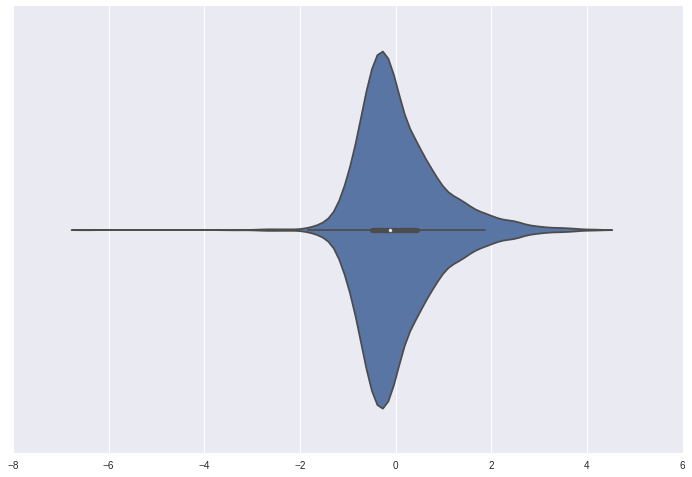

In [13]:
sns.violinplot(Y_cv - yp_cv)

In [10]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(10, n_jobs=-1)
model.fit(X_t, Y_t)
Knn_cv = model.predict(X_cv)

0.896089651194


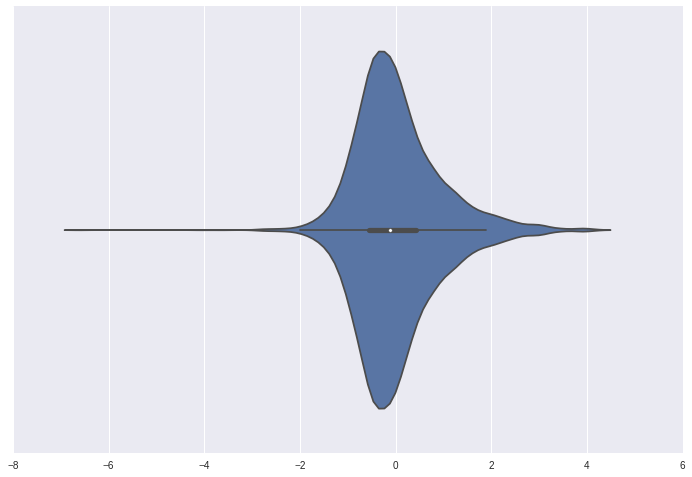

In [11]:
print (np.sqrt(np.mean(np.square(Y_cv - Knn_cv))))
sns.violinplot(Y_cv - Knn_cv)